In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import json
from tools import create_x_y

In [3]:
def encode_y(y):
    if len(set(y)) == 2:
        remap_dict = {-1: 0, 1: 1}
    elif len(set(y)) == 3:
        remap_dict = {-1: 0, 0: 1, 1: 2}
    elif len(set(y)) == 5:
        remap_dict = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}
    for i, val in enumerate(y):
        y[i] = remap_dict[val]

    return y


def weight_data(x):
    # least represented class is 1.0, others are percentage_least/percentage_other
    percentages = {}
    len_x = len(x)
    for uniq_val in set(x):
        percentages[uniq_val] = sum([1 for i in x if i == uniq_val]) / len_x
    least = min(percentages, key=percentages.get)
    weights = {i: percentages[least] / percentages[i] for i in percentages}
    return weights


# match feature importances from vector with multiple lagged vals of each column
def importances_from_lag(x, col_names):
    lag = int(len(x) / len(col_names))
    len_col = len(col_names)
    imp = {
        col_names[i]: sum(x[i * lag : (i + 1) * lag]) / lag
        for i in range(len_col)
    }

    return imp

def save_importances_plot(fi, name, title, cols):
    import seaborn as sns
    importances = importances_from_lag(fi, cols) 
    x_axis = list(importances.keys())
    y_axis = [float(i) for i in importances.values()]
    figure = plt.gcf()
    figure.set_size_inches(9, 6)
    sns.barplot(y=x_axis, x=y_axis).set_title(title)
    
    plt.savefig(f'../plots/{name}.pdf')

In [4]:
def measure(x, y, binary=True):
    mode = "binary:logistic"
    if not binary:
        mode = "multi:softprob"
    clf = xgb.XGBClassifier(objective=mode, random_state=42)

    params = {
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 0.5),
        "learning_rate": uniform(0.003, 0.3),  # default 0.1
        "max_depth": randint(2, 6),  # default 3
        "n_estimators": randint(100, 400),  # default 100
        "subsample": uniform(0.6, 0.4), 
    }
    time_split = TimeSeriesSplit(n_splits=5)
    xgb_search = RandomizedSearchCV(
        clf,
        param_distributions=params,
        random_state=42,
        n_iter=20,
        cv=time_split,
        verbose=1,
        n_jobs=4,
    )
    split = int(0.8 * len(x))
    xgb_search.fit(x[:split], y[:split])
    y_pred = xgb_search.predict(x[split:])
    #cm = confusion_matrix(y[split:], y_pred)
    acc = accuracy_score(y[split:], y_pred)
    f1 = f1_score(y[split:], y_pred, average="weighted")

    fi = xgb_search.best_estimator_.feature_importances_

    return acc, f1, fi

['open', 'high', 'low', 'close', 'vol']
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


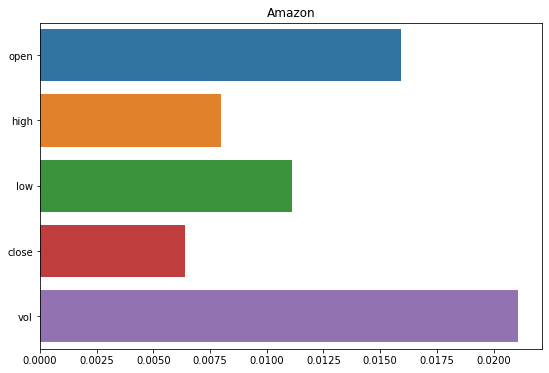

In [7]:
full_names = {
    "amzn": "Amazon",}
#     "aapl": "Apple",
#     "msft": "Microsoft",
#     "tsla": "Tesla",
#     "goog": "Google (GOOG)",
#     "googl": "Google (GOOGL)",
# }
weight = "baseline_2"

acc = {}
cm = {}
f1_metric = {}

path = f"../datasets/v2.1/more_cols_binned/no_weight/"

for company in full_names.keys():
    df = pd.read_csv(path + f"{company}.csv")
    # VITAL_COLS = ["date_", "ticker", "bin_2", "diffs", "bin_3"]
    # OTHER_COLS = [i for i in df.columns if i not in VITAL_COLS]
    OTHER_COLS = ["open", "high", "low", "close", "vol"]
    
    print(OTHER_COLS)
    acc[company] = {}
    f1_metric[company] = {}
    fi = {}

    for lag in [3, 6, 10, 16]:
        x, y = create_x_y(df, x_cols=OTHER_COLS, y_col="bin_2", lag=lag)
        y = encode_y(y)
        # print(x[:3], y[:3])
        # print(acc, f1_metric, fi)
        acc[company][lag], f1_metric[company][lag], fi[lag] = measure(
            x, y, binary=True
        )
    save_importances_plot(
        fi[lag],
        f"xgb_{company}_imp_{weight}",
        f"{full_names[company]}",
        OTHER_COLS,
    )
with open(f"XGB_{company}_acc_f1_{weight}.txt", "w") as file:
    to_write = "Acc: " + json.dumps(acc) + " F1: " + json.dumps(f1_metric)
    file.write(json.dumps(to_write))

['open', 'high', 'low', 'vol', 'comment_num_sum', 'comp_max', 'comp_mean', 'comp_median', 'comp_min', 'comp_std', 'like_num_sum', 'neg_max', 'neg_mean', 'neg_median', 'neg_min', 'neg_std', 'neu_max', 'neu_mean', 'neu_median', 'neu_min', 'neu_std', 'count', 'pos_max', 'pos_mean', 'pos_median', 'pos_min', 'pos_std', 'retweet_num_sum', 'relative_count']
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


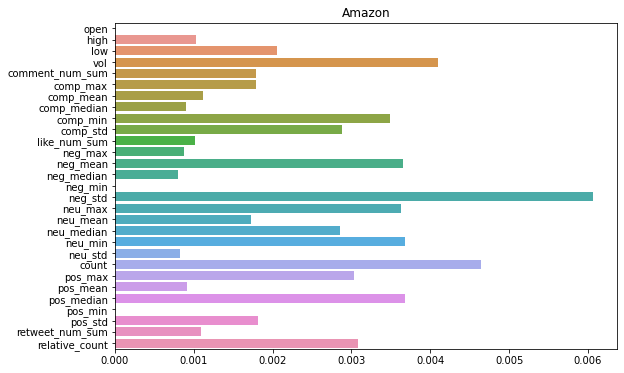

In [8]:
full_names = {
    "amzn": "Amazon",
}
#     "aapl": "Apple",
#     "msft": "Microsoft",
#     "tsla": "Tesla",
#     "goog": "Google (GOOG)",
#     "googl": "Google (GOOGL)",
# }
weight = "w1"

acc = {}
cm = {}
f1_metric = {}

path = f"../datasets/v2.1/more_cols_binned/{weight}/"

for company in full_names.keys():
    df = pd.read_csv(path + f"{company}.csv")
    VITAL_COLS = ["post_date", "ticker", "diffs", "bin_2", "bin_3", "close"]
    OTHER_COLS = [i for i in df.columns if i not in VITAL_COLS]
    print(OTHER_COLS)
    acc[company] = {}
    f1_metric[company] = {}
    fi = {}

    for lag in [3, 6, 10, 16]:
        x, y = create_x_y(df, x_cols=OTHER_COLS, y_col="bin_2", lag=lag)
        y = encode_y(y)
        #print(x[:3], y[:3])
        #print(acc, f1_metric, fi)
        acc[company][lag], f1_metric[company][lag], fi[lag] = measure(
            x, y, binary=True
        )
    save_importances_plot(
            fi[lag],
            f"xgb_{company}_imp_{weight}",
            f"{full_names[company]}",
            OTHER_COLS,
        )
    with open(f"XGB_bin2_{company}_acc_f1_{weight}.txt", "w") as file:
        to_write = "Acc: " + json.dumps(acc) + " F1: " + json.dumps(f1_metric)
        file.write(json.dumps(to_write))


In [27]:
acc

{'tsla': {3: 0.3563615428900403,
  6: 0.3747841105354059,
  10: 0.35368663594470046,
  16: 0.3723342939481268}}

In [21]:
acc_good = {f"{company}_{lag}": round(acc[company][lag], 4) for lag in acc[company] for company in acc}
f1_good = {f"{company}_{lag}": round(f1_metric[company][lag], 4) for lag in acc[company] for company in acc}

In [23]:
f1_good

{'amzn_3': 0.491, 'amzn_6': 0.498, 'amzn_10': 0.4935, 'amzn_16': 0.4916}

Text(0.5, 1.0, 'F1')

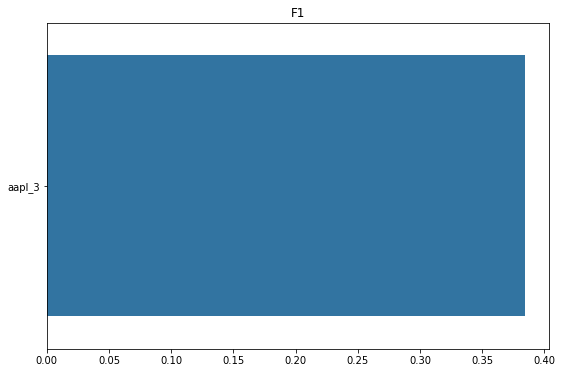

In [11]:
import seaborn as sns

figure = plt.gcf()
figure.set_size_inches(9, 6)
sns.barplot(x=list(f1_good.values()), y=list(f1_good.keys())).set_title("F1")
